# Human Activity Recognition using TSFEL

On this example we will perform Human Activty Recognition using our library **Time Series Features Library**. 

The first step consists on importing the library. Press play. 

The import can take a few seconds, but the play button will change so that you know the import has started. Please, try to import just once.

In [0]:
#@title Import Time Series Features Library
!git clone https://github.com/TSFDlib/TSFEL.git >/dev/null 2>&1
!pip install --upgrade -q gspread >/dev/null 2>&1
!pip install gspread oauth2client >/dev/null 2>&1
!pip install pandas >/dev/null 2>&1
!pip install scipy >/dev/null 2>&1
!pip install novainstrumentation >/dev/null 2>&1
!pip install pandas_profiling >/dev/null 2>&1

To check if everything was correctly imported, access "Files" (on the left side of the screen) and press "Refresh". If a TSFEL paste does not appear import again.

---


#Dataset

The dataset we will be using is open-source. It is provided by UCI and it was performed by 30 volunteers using a smartphone on the waist. It contains 6 activities: 

*   Walking
*   Standing
*   Sitting
*   Laying
*   Upstairs
*   Downstairs

To access this dataset click [here](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/) and dowload the zip "UCI_HAR_Dataset". Now, unzip the folder and upload to "Files" the following txt:

*   UCI HAR Dataset/train/Inertial Signals/total_acc_x_train.txt
*   UCI HAR Dataset/train/Inertial Signals/total_acc_y_train.txt
*   UCI HAR Dataset/train/Inertial Signals/total_acc_z_train.txt
*   UCI HAR Dataset/test/Inertial Signals/total_acc_x_test.txt
*   UCI HAR Dataset/test/Inertial Signals/total_acc_y_test.txt
*   UCI HAR Dataset/test/Inertial Signals/total_acc_z_test.txt
*   UCI HAR Dataset/train/y_train.txt
*   UCI HAR Dataset/test/y_test.txt
*   UCI HAR Dataset/activity_labels.txt






In [0]:
#@title Data Preparation
# Import libraries
import pandas as pd 
import numpy as np
import TSFEL as tslib
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
sns.set()

# Load data
x_train_sig = np.loadtxt('total_acc_x_train.txt', dtype='float32')
x_test_sig = np.loadtxt('total_acc_x_test.txt', dtype='float32')
y_test = np.loadtxt('y_test.txt', dtype='float32')
y_train = np.loadtxt('y_train.txt', dtype='float32')
labels = np.array(pd.read_csv('activity_labels.txt', header=None, delimiter=' '))[:,1]

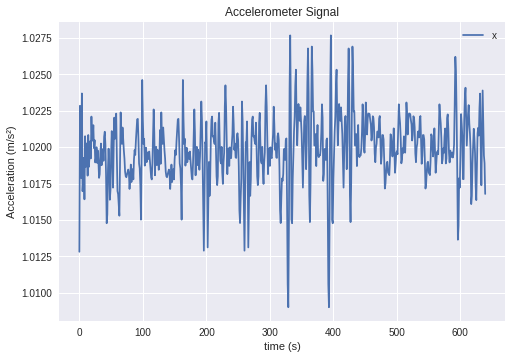

In [5]:
#@Signal Preview
plt.figure()
plt.plot(np.concatenate(x_train_sig[0:5]))
plt.xlabel("time (s)")
plt.ylabel("Acceleration (m/s²)")
plt.title("Accelerometer Signal")
plt.legend('x axis')
plt.show()

#Feature Extraction

The features to extract are defined in the [google sheet](https://docs.google.com/spreadsheets/d/15Db3m7if7xkZBqHDUXtFxrwIcBqKvIBU0XnV6aKa4SI/edit?ts=5bd1eca0#gid=0).

Through **Feature Extraction** methodologies, the data is translated into a feature vecture containing information about the signal properties of each window. These properties can be classifier according to their domain as Time, Frequency and Statistical features and allow to characterise the signal in a compact way, enhancing its chracteristics. This features will be used as input to the machine learning classifier, thus, the chosen set of features can strongly influence the classification output.

A feature report is saved in /utils.

In [6]:
#@title Feature Extraction

# Extract excel info
cfg_file = tslib.extract_sheet()

# Get features
X_train = tslib.extract_features(x_train_sig, cfg_file, segment=False)
X_test = tslib.extract_features(x_test_sig, cfg_file, segment=False)

TypeError: ignored

# Feature Selection

After the sensor data is extracted, redundancies and noise should be removed. Thus, minimising the algorithm's error, time and computational complexity. 

In [0]:
# Concatenation of entire data
features = pd.concat([X_train,X_test])
# Highly correlated features are removed
features = tslib.correlation_report(features)
X_train = features[:len(X_train)]
X_test = features[len(X_train):]

Do you wish to remove correlated features? Enter y/n: y
Removing x_Mean
Removing x_Mean absolute diff
Removing x_Median
Removing x_Median absolute deviation
Removing x_Minimum peaks
Removing x_Root mean square
Removing x_Spectral centroid
Removing x_Spectral roll-off
Removing x_Spectral skewness
Removing x_Spectral slope
Removing x_Standard Deviation
Removing x_Sum absolute diff
Removing x_Total energy
Removing x_Variance


In [0]:
#@title Preview Features


#Classification

In this example the classification is performed with a [Decision Tree](https://scikit-learn.org/stable/modules/tree.html) classifier.
  

In [0]:
classifier = DecisionTreeClassifier()

# Train the classifier
classifier.fit(X_train, y_train.ravel())

# Predict test data
y_test_predict = classifier.predict(X_test)

# Get the classification report
accuracy = accuracy_score(y_test, y_test_predict)
print(classification_report(y_test, y_test_predict, labels))
print("Accuracy: " + str(accuracy) + '%')

Accuracy: 0.7360027146250424%


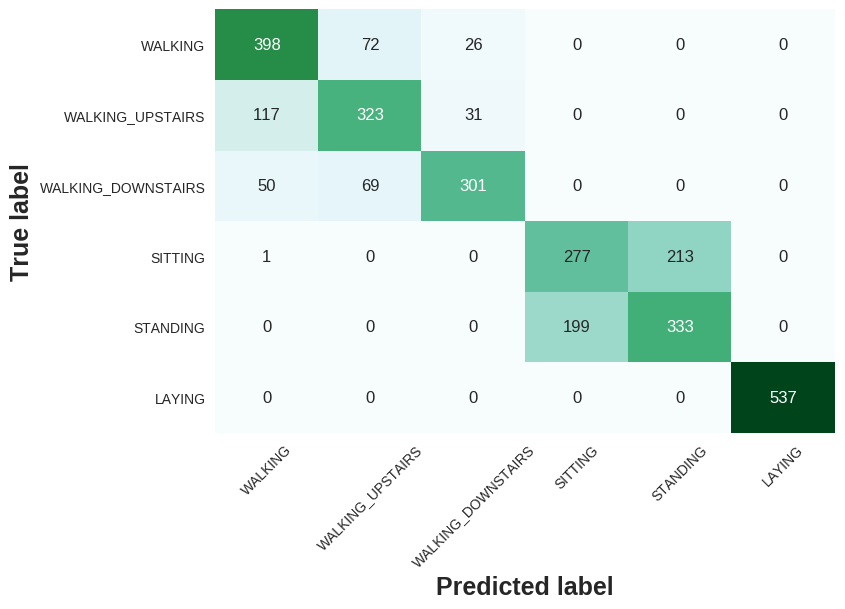

In [0]:
cm = confusion_matrix(y_test, y_test_predict)
df_cm = pd.DataFrame(cm, index=[i for i in labels], columns=[i for i in labels])
plt.figure()
ax = sns.heatmap(df_cm,  cbar = False, cmap="BuGn", annot=True, fmt="d")
plt.setp(ax.get_xticklabels(), rotation=45)
plt.ylabel('True label', fontweight='bold', fontsize = 18)
plt.xlabel('Predicted label', fontweight='bold', fontsize = 18)
plt.show()


# Conclusion

As it can be seen in the confusion matrix, the misclassification was higher between WALKING UPSTAIRS vs WALKING DOWNSTAIRS vs WALKING and SITTING vs STANDING. Dynamic activities, due to their distinct motion characteristics and cyclic behaviour, were clearly discriminated against static activities.

In [8]:
#@title Improvements

# Load data
y_train_sig = np.loadtxt('total_acc_y_train.txt', dtype='float32')
y_test_sig = np.loadtxt('total_acc_y_test.txt', dtype='float32')
z_train_sig = np.loadtxt('total_acc_z_train.txt', dtype='float32')
z_test_sig = np.loadtxt('total_acc_z_test.txt', dtype='float32')
      
#declare empty array
mag_train = []
#get accelerometer data magnitude
for i in range(0,len(x_train_sig)):
    mag_row= []
    for j in range(len(x_train_sig[i])):
        mag_row.append(np.sqrt(x_train_sig[i,j]**2 + y_train_sig[i,j]**2 + z_train_sig[i,j]**2))
    mag_train.append(mag_row)
mag_train = np.array(mag_train)

mag_test = []
for i in range(0,len(x_test_sig)):
    mag_row= []
    for j in range(len(x_test_sig[i])):
        mag_row.append(np.sqrt(x_test_sig[i,j]**2 + y_test_sig[i,j]**2 + z_test_sig[i,j]**2))
    mag_test.append(mag_row)
mag_test = np.array(mag_test)

## Data Preparation
train_sig = np.array(zip(x_train_sig, y_train_sig, z_train_sig, mag_train))
test_sig = np.array(zip(x_test_sig, y_test_sig, z_test_sig, mag_test))

## Feature Selection
# Extract excel info
cfg_file = tslib.extract_sheet()
# Get features
X_train = tslib.extract_features(train_sig, cfg_file, segment=False)
X_test = tslib.extract_features(test_sig, cfg_file, segment=False)

## Feature Selection
# Concatenation of entire data
features = pd.concat([X_train,X_test])
# Highly correlated features are removed
features = tslib.correlation_report(features)
X_train = features[:len(X_train)]
X_test = features[len(X_train):]


# Classification
classifier = DecisionTreeClassifier()
# Train the classifier
classifier.fit(X_train, y_train.ravel())
# Predict test data
y_test_predict = classifier.predict(X_test)

# Get the classification report
accuracy = accuracy_score(y_test, y_test_predict)
print(classification_report(y_test, y_test_predict, labels))
print("Accuracy: " + str(accuracy) + '%')

TypeError: ignored

In [19]:
print(mag_test.shape[1])

128
